<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/animals_localisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import imutils

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG
from skimage.transform import pyramid_gaussian

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [11]:
import h5py
train = h5py.File('/content/drive/My Drive/animals/animals_large.h5', "r")

XX= train["X"][:]
ZZ =train["Z"][:]
# names=train["names"][:]
num = XX.shape[0] 
print(XX.shape,ZZ.shape)

(17384, 224, 224, 3) (17384,)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(XX,Z,test_size=0.05,random_state=42)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(16514, 224, 224, 3) (16514,) (870, 224, 224, 3) (870,)


In [12]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
# tr,va,te=Z_train,Z_val,Z_test
ZZ= to_categorical(ZZ,7)
# y_test= to_categorical(y_test,7)



XX=XX/255


# x_test=x_test/255
# print(X.shape,Z.shape)
# x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
# print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
# print(x_train.shape,y_train.shape)
print(XX.shape,ZZ.shape)

(17384, 224, 224, 3) (17384, 7)


In [0]:
# x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
# print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
# augs_gen.fit(x_train)
augs_gen.fit(XX)

17384


NameError: ignored

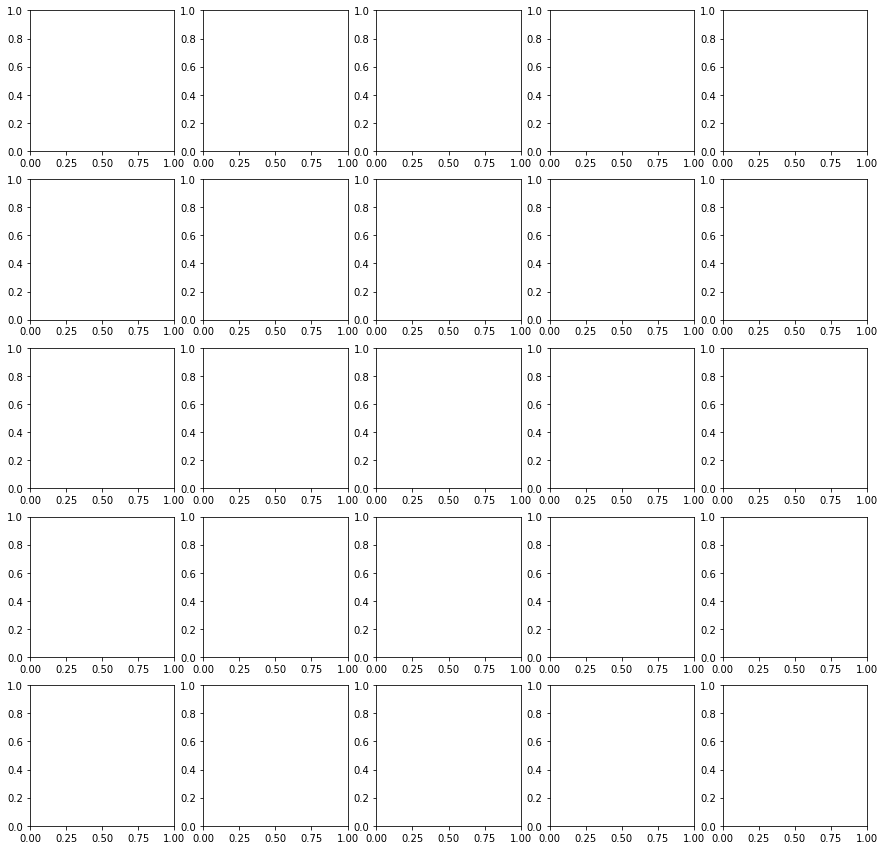

In [8]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Grocery: '+ str(Z[l]))
        
plt.tight_layout()





553467904/553467096 [==============================] - 34s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

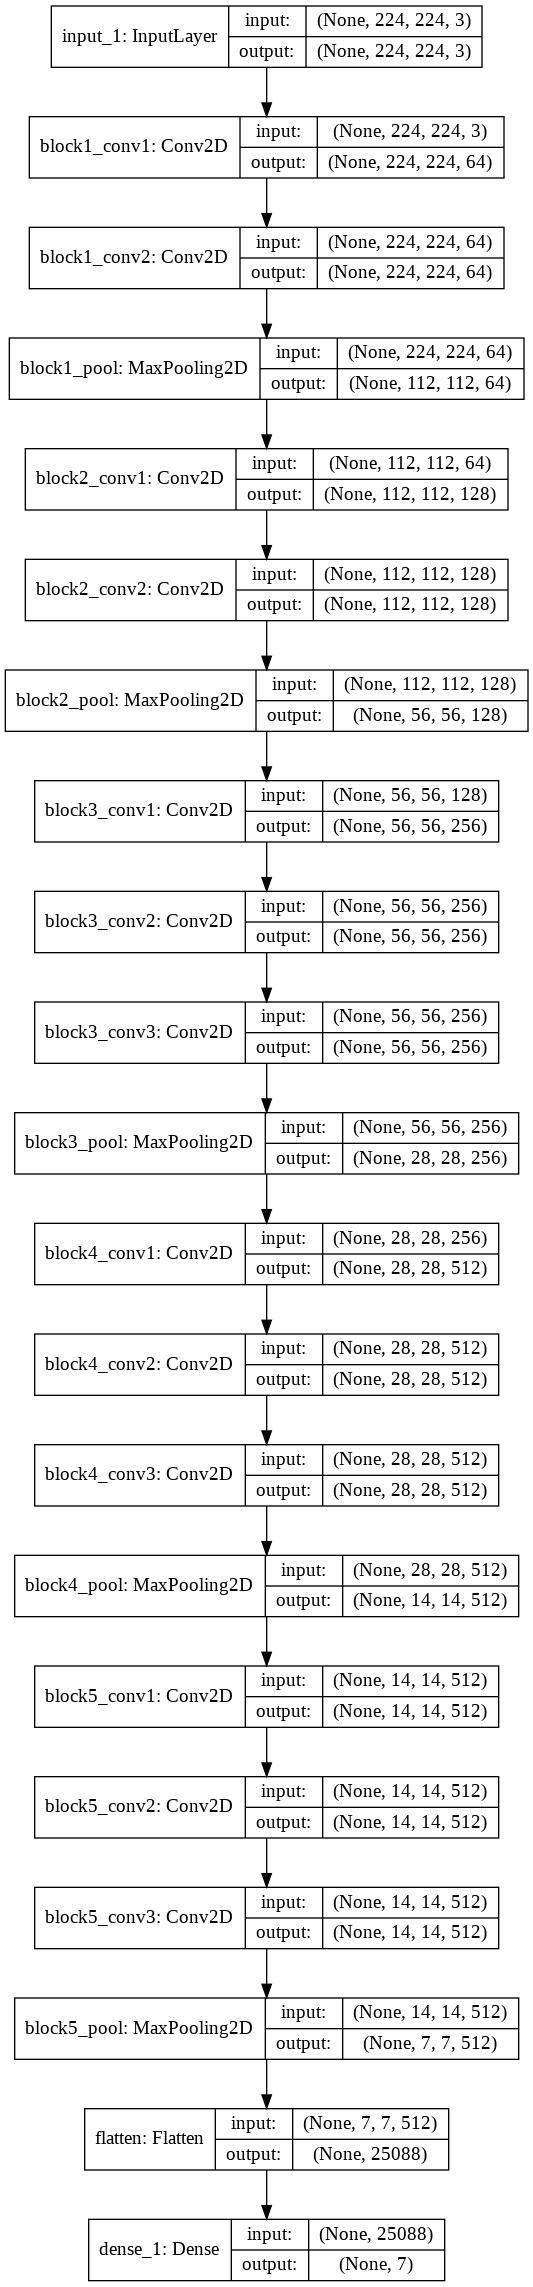

In [5]:
imgsize=224
base_model = VGG16(include_top=True,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
# base_model.layers.pop()
# base_model.layers.pop()
# base_model.layers.pop()

model = Sequential()
for layer in base_model.layers[:-3]:
  model.add(layer)

for layer in model.layers[:-1]:
  layer.trainable = False

for layer in model.layers:
  print(layer,layer.trainable)


# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
# model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(7,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

# callbacks = [checkpoint,tensorboard,csvlogger,reduce]
callbacks = [earlystop,tensorboard,csvlogger,reduce]

In [9]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)


# history = model.fit(
#     x_train,y_train,batch_size=32,
#     validation_data  = (x_test,y_test),
#     # validation_steps = 100,
#     # steps_per_epoch  = 10,
#     epochs = 40,
#     verbose = 1,
#     callbacks=callbacks
# )
history = model.fit_generator(
    augs_gen.flow(XX/255,to_categorical(ZZ,7),batch_size=128),
    validation_data  = (x_test,y_test),
    validation_steps = 100,
    # steps_per_epoch  = 100,
    epochs =15, 
    verbose = 1,
    callbacks=callbacks
)

KeyboardInterrupt: ignored

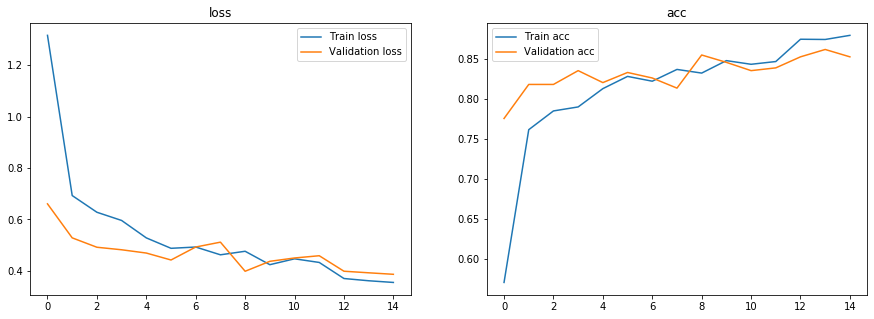

In [11]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [12]:
a=model.evaluate(x_train,y_train)
b=model.evaluate(x_test,y_test)
# c=model.evaluate(x_val,y_val)

print(a)
print(b)
# print(c)
ind=0

870/870 [==============================] - 3s 3ms/step


NameError: ignored

(17384,)
[[0.37815157 0.00083936 0.22188686 0.0609174  0.3351483  0.00152783
  0.00152867]]
[[1.03625335e-01 7.83862255e-04 6.10377431e-01 9.26887691e-02
  1.91814288e-01 3.77205783e-04 3.33109987e-04]]


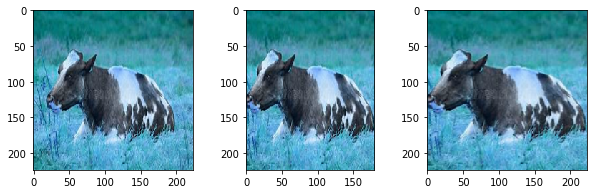

In [14]:
ind=2338

X=x_train
# Z=Z
print(Z.shape)
a=model.predict(X[ind].reshape(1,224,224,3))
# c=model.evaluate(X[ind].reshape(1,224,224,3),Z[ind].reshape(1,7))

crop=X[ind][:,20:200]
img = cv2.resize(crop,(224,224))
b=model.predict(img.reshape(1,224,224,3))
# d=model.evaluate(img.reshape(1,224,224,3),Z[ind].reshape(1,7))
(img.reshape(1,224,224,3))

print(a)
print(b)
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.imshow(X[ind])
plt.subplot(3,3,2)
plt.imshow(crop)
plt.subplot(3,3,3)
plt.imshow(img)

(1, 224, 224, 3)
[[0.0000000e+00 0.0000000e+00 3.4586058e-34 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00]]
(200, 200, 3)
[[0. 0. 1. 0. 0. 0. 0.]]


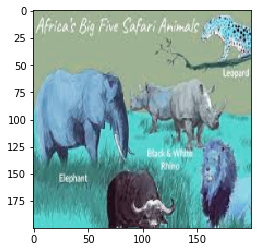

In [15]:
img=cv2.imread('/content/images (5).jpg',cv2.IMREAD_COLOR)
ig=cv2.resize(img,(224,224)).reshape(1,224,224,3)
print(ig.shape)
b=model.predict(ig)
print(b)

qq=ig.reshape(224,224,3)
qq=qq[:200,:200,:]
print(qq.shape)
b=model.predict(cv2.resize(qq,(224,224)).reshape(1,224,224,3))
print(b)

plt.imshow(qq)

[[0. 0. 0. 0. 1. 0. 0.]]


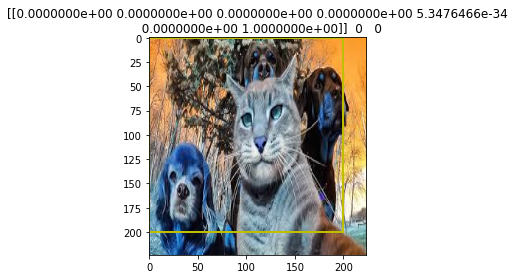

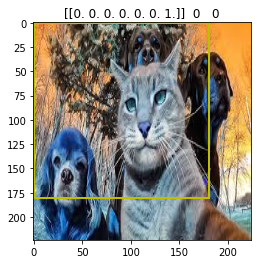

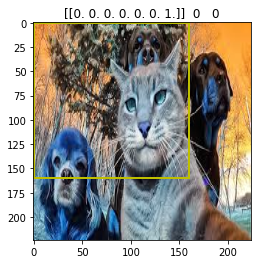

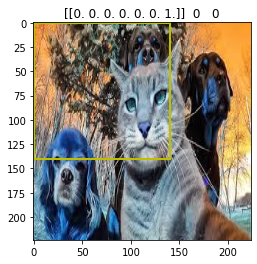

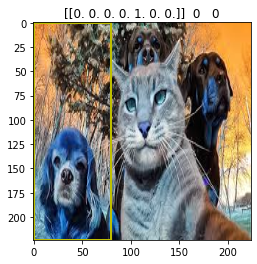

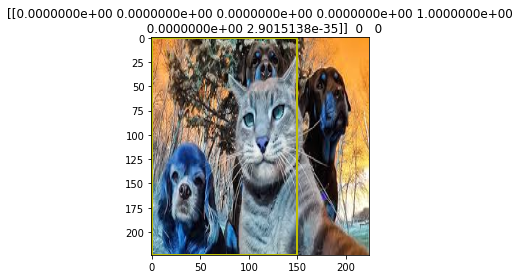

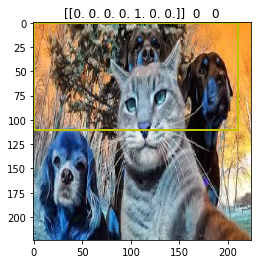

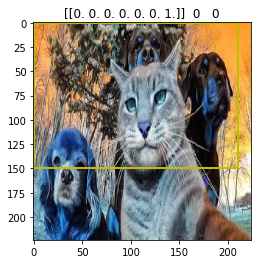

In [16]:
img=cv2.imread('/content/images (9).jpg',cv2.IMREAD_COLOR)
ig=cv2.resize(img,(224,224)).reshape(1,224,224,3)
b=model.predict(ig)
print(b)
ig=ig.reshape(224,224,3)
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
   
max1 = 0
winW, winH = 80,80
# image shape is 3 dimension
diff_sizes=[(200,200),(180,180),(160,160),(140,140),(80,224),(150,224),(210,110),(210,150)]
for size in diff_sizes:
  winW , winH= size[0],size[1]
  max1=0
  for (x, y, window) in sliding_window(ig, stepSize=4, windowSize=(winW, winH)):
    # print(window.shape)

    if window.shape[0] != winH or window.shape[1] != winW:
      continue
    # print(window.shape)
    # print(1)
    img = cv2.resize(window,(224,224))
    pred=model.predict(img.reshape(1,224,224,3))
    indmax=np.argmax(pred)
    if pred[0][indmax]>max1:
      max1=pred[0][indmax]
      x1,y1,window1=x,y,window
      b1=pred
  # print(b1)

  import matplotlib.patches as patches

  # Create figure and axes
  fig,ax = plt.subplots(1)
  # Display the image
  plt.title('{}  {}   {}'.format(b1,x1,y1))
  ax.imshow(ig)
  
  # Create a Rectangle patch
  length,height=winW, winH
  rect = patches.Rectangle((x1,y1),length,height,linewidth=2,edgecolor='y',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)
plt.show()




(200, 200, 3)


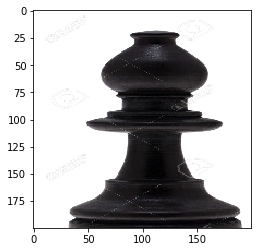

In [0]:
[0, 2, 68, 72, 78, 79, 81, 82, 84, 90, 108, 140, 149, 182, 302, 360, 363, 386, 396, 467, 479, 499, 528]
print(arg.shape)
plt.imshow(arg)